<h3>Goal of the project: Create a binary classification model to predict good or bad to be given credit</h3>

<b>Attributes - Independent Variables</b> (Descriptions based on dataset documentation):
<ul>
    <li><span style="color:#26a06c">checking_status</span> : Status of existing checking account</li>
    <li><span style="color:#26a06c">duration</span> : Duration in months</li>
    <li><span style="color:#26a06c">credit_history</span> : credits taken, paid back duly, delays, critical accounts</li>
    <li><span style="color:#26a06c">purpose</span> : Purpose of the credit</li>
    <li><span style="color:#26a06c">credit_amount</span> : Amount of credit</li>
    <li><span style="color:#26a06c">savings_status</span> : Status of savings account/bond</li>
    <li><span style="color:#26a06c">employment</span> : Present employment, in number of years</li>
    <li><span style="color:#26a06c">installment_commitment</span> : Installment rate in percentage of disposable income</li>
    <li><span style="color:#26a06c">personal_status</span> : Sex and marital data</li>
    <li><span style="color:#26a06c">other_parties</span> : Other debtors / guarantors</li>
    <li><span style="color:#26a06c">residence_since</span> : (no documentation) looks like residency in years</li>
    <li><span style="color:#26a06c">property_magnitude</span> : (no documentation) looks like the property of the customer but it's unclear</li>
    <li><span style="color:#26a06c">age</span> : Age of the customer</li>
    <li><span style="color:#26a06c">other_payment_plans</span> : (no documentation) most likely refers to other credits by the customer</li>
    <li><span style="color:#26a06c">housing</span> : refers to the owenership status of the customer to the house he/she lives</li>
    <li><span style="color:#26a06c">job</span> : (no documentation) looks like a general skillset description of the customer</li>
    <li><span style="color:#26a06c">num_dependents</span> : Number of dependents on the customer</li>
    <li><span style="color:#26a06c">own_telephone</span> : If the customer owns or not a phone</li>
    <li><span style="color:#26a06c">foreign_worker</span> : If the customer is foreign worker or not</li>
</ul>
<b>Target - Dependent Variable</b>:
<ul>
    <li><span syle="color:#3498db">class</span> : if the customer is good or bad to be given credit.</li>
</ul>
    

    




Imports

In [37]:
import os
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score, make_scorer, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imbPipeline

from catboost import CatBoostClassifier

from skopt.space import Integer, Real
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt import BayesSearchCV

import shap

sns.set_style("darkgrid")

if not os.path.exists("../datasets"):
    os.makedirs("../datasets")

PROJECT_URL = "https://www.kaggle.com/datasets/ppb00x/credit-risk-customers"
PROJECT_NAME = PROJECT_URL.split("/")[-1]
DATA_PATH = os.path.join("../datasets", PROJECT_NAME)
od.download(PROJECT_URL, "../datasets")
start_time = time.time()

Skipping, found downloaded files in "../datasets/credit-risk-customers" (use force=True to force download)


Functions

In [2]:
def double_countplots(df, cols, rotation=[None, None]):
    plt.figure(figsize=(14,5))
    ax1 = plt.subplot(1,2,1)
    sns.countplot(x=df[cols[0]], ax=ax1)
    for c in ax1.containers:
        ax1.bar_label(c)
    if rotation[0]:   
        plt.xticks(rotation=rotation[0])
    ax2 = plt.subplot(1,2,2)
    sns.countplot(x=df[cols[1]], ax=ax2)
    for c in ax2.containers:
        ax2.bar_label(c)
    if rotation[1]:        
        plt.xticks(rotation=rotation[1])
    plt.show()

In [3]:
df = pd.read_csv(os.path.join(DATA_PATH, os.listdir(DATA_PATH)[0]))

<h2>EDA</h2>

In [4]:
df.duplicated().sum()

0

In [5]:
df.shape

(1000, 21)

In [6]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   object 
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   object 
 14  housing                 1000 non-null   o

In [8]:
df.describe().style.format("{:.2f}")

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,20.90,3271.26,2.97,2.85,35.55,1.41,1.16
std,12.06,2822.74,1.12,1.10,11.38,0.58,0.36
min,4.00,250.00,1.00,1.00,19.00,1.00,1.00
25%,12.00,1365.50,2.00,2.00,27.00,1.00,1.00
50%,18.00,2319.50,3.00,3.00,33.00,1.00,1.00
75%,24.00,3972.25,4.00,4.00,42.00,2.00,1.00
max,72.00,18424.00,4.00,4.00,75.00,4.00,2.00


In [9]:
df.describe(include=["object"]).T

,count,unique,top,freq
checking_status,1000,4,no checking,394
credit_history,1000,5,existing paid,530
purpose,1000,10,radio/tv,280
savings_status,1000,5,<100,603
employment,1000,5,1<=X<4,339
personal_status,1000,4,male single,548
other_parties,1000,3,none,907
property_magnitude,1000,4,car,332
other_payment_plans,1000,3,none,814
housing,1000,3,own,713


In [10]:
# check the unique values of numerical columns
for c in df.select_dtypes(include=["float64", "int64"]).columns.tolist():
    unique_vals = df[c].nunique()
    percent = (unique_vals/df.shape[0])*100
    print(f"Column {c} has {percent:.2f} % unique values")

Column duration has 3.30 % unique values
Column credit_amount has 92.10 % unique values
Column installment_commitment has 0.40 % unique values
Column residence_since has 0.40 % unique values
Column age has 5.30 % unique values
Column existing_credits has 0.40 % unique values
Column num_dependents has 0.20 % unique values


<span style="background-color:#76d7c4;color:black;border-radius:3px;opacity:0.8;font-size:120%">Univariate Analysis</span>

Mutual information

<Axes: >

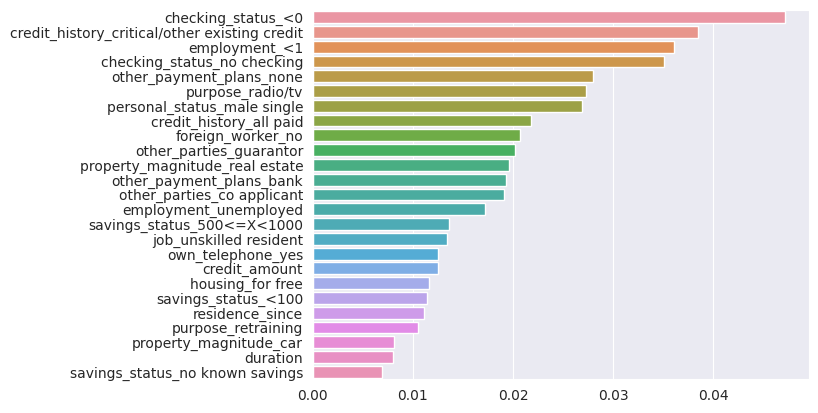

In [11]:
# Mutual information
X, y = pd.get_dummies(df.drop(columns=["class"])), df["class"].copy()
mi = mutual_info_classif(X,y)
mi_scores = pd.Series(mi, index=X.columns.tolist()).sort_values(ascending=False).head(25)
sns.barplot(x=mi_scores.values, y=mi_scores.index)

Plots

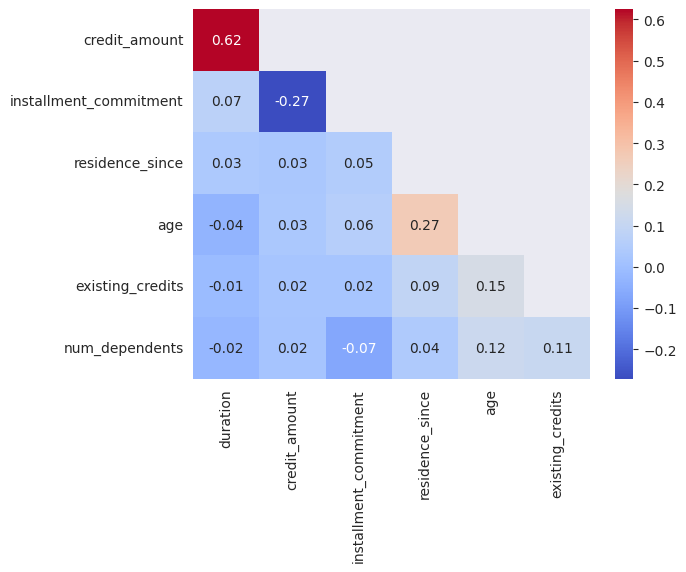

In [12]:
corr = df.select_dtypes(exclude=["object"]).corr()
mask = np.triu(np.ones_like(corr))[1:,:-1]
sns.heatmap(corr.iloc[1:, :-1], annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.grid(False)

<Axes: xlabel='credit_amount', ylabel='Count'>

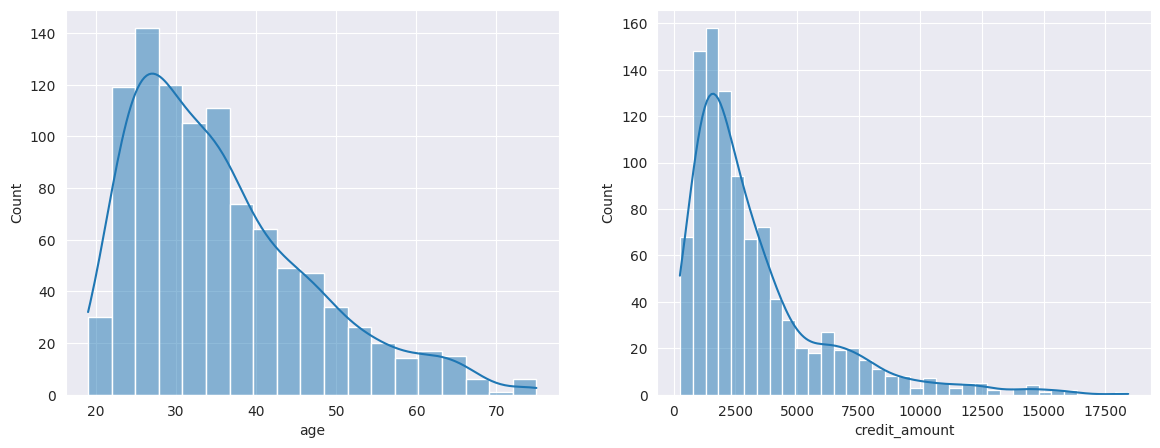

In [13]:
plt.figure(figsize=(14,5))
ax1 = plt.subplot(1,2,1)
sns.histplot(df["age"].astype(int), kde=True, ax=ax1)
ax2 = plt.subplot(1,2,2)
sns.histplot(df["credit_amount"], kde=True, ax=ax2)

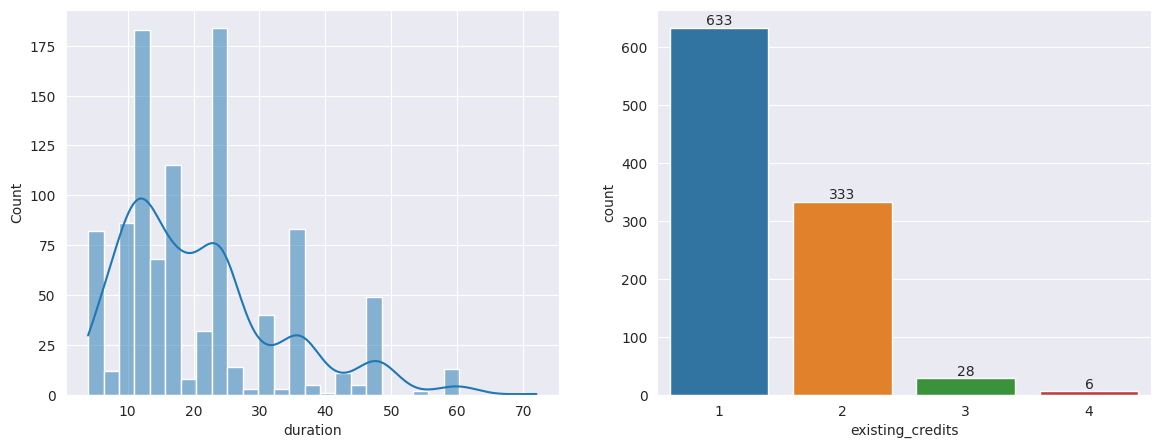

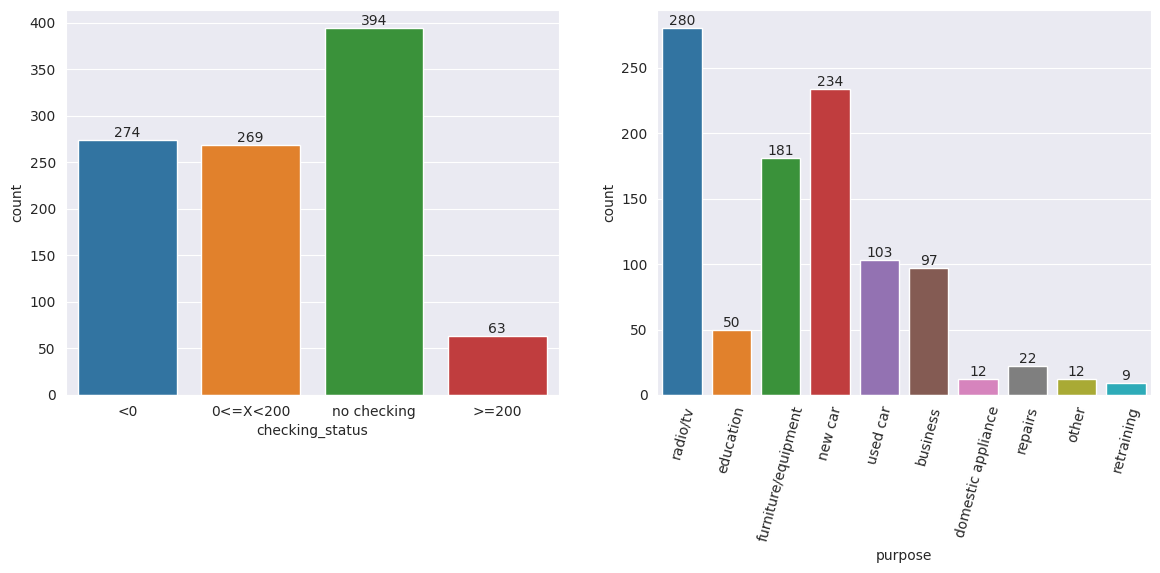

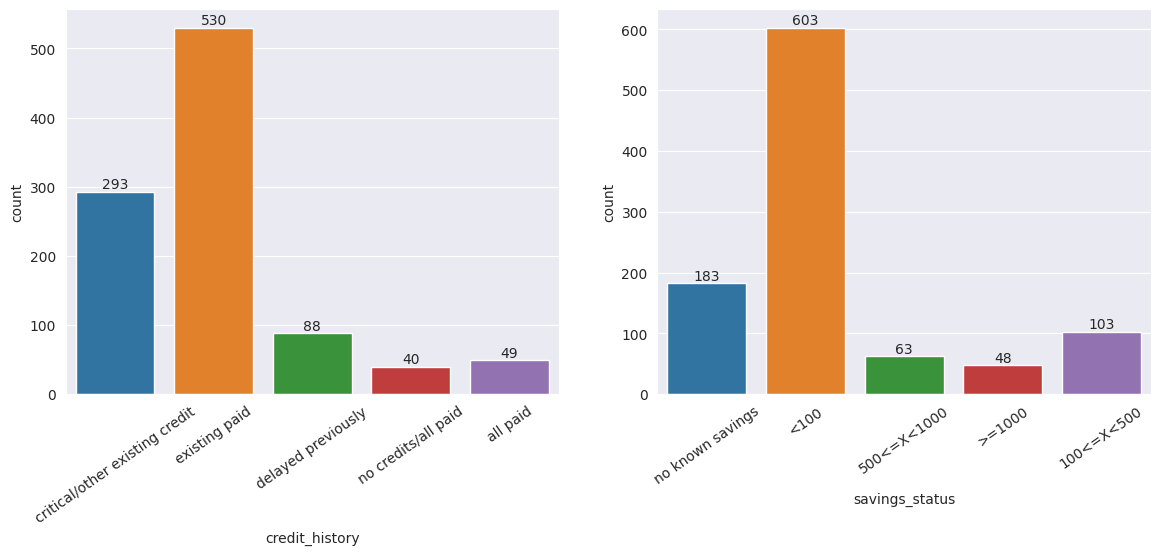

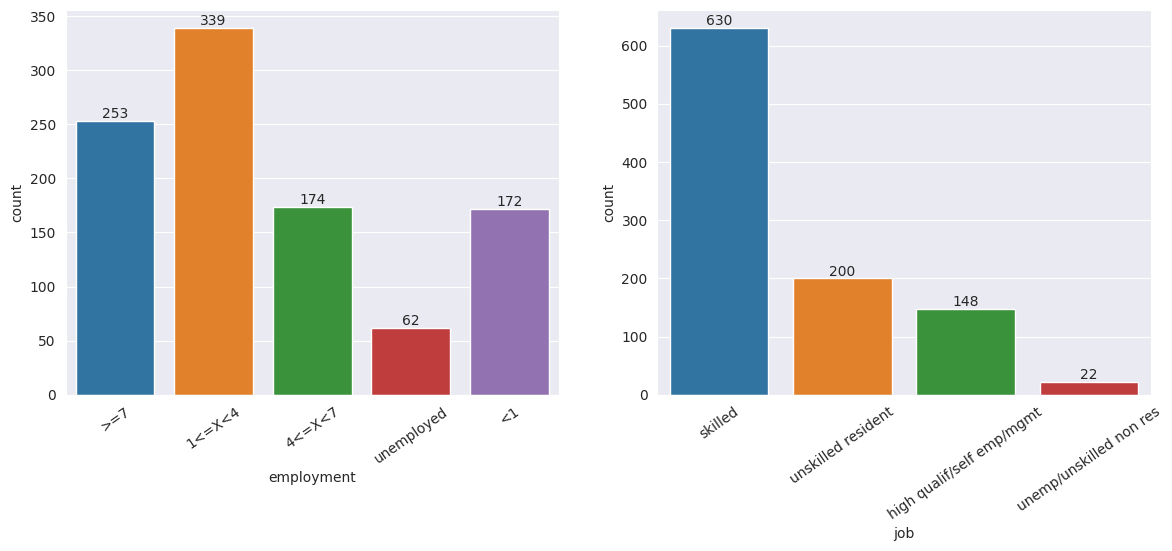

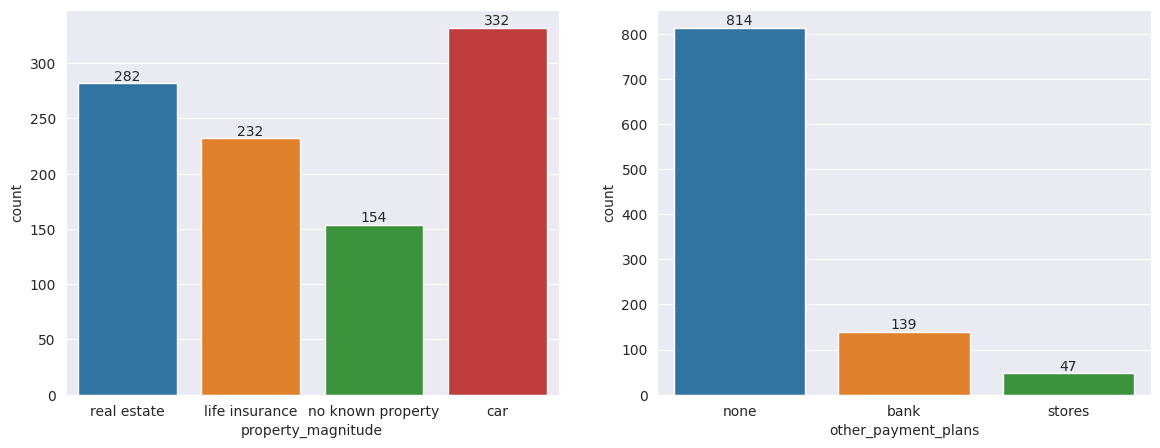

In [14]:
plt.figure(figsize=(14,5))
ax1 = plt.subplot(1,2,1)
sns.histplot(df["duration"].astype(int), kde=True, ax=ax1)
ax2 = plt.subplot(1,2,2)
sns.countplot(x=df["existing_credits"].astype(int), ax=ax2)
for c in ax2.containers:
    ax2.bar_label(c)
plt.show()

double_countplots(df, ["checking_status", "purpose"], rotation=[None, 75])
double_countplots(df, ["credit_history", "savings_status"], rotation=[35,35])
double_countplots(df, ["employment", "job"], rotation=[35,35])
double_countplots(df, ["property_magnitude", "other_payment_plans"])

<b>Observations:</b>
<ul>
    <li><span style="color:#26a06c">checking_status</span>, <span style="color:#26a06c">saving_status</span> and <span style="color:#26a06c">duration</span> have the highest mutual information with <span syle="color:#3498db">class</span>.</li>
    <li><span style="color:#26a06c">age</span> and <span style="color:#26a06c">credit_amount</span> are slightly left skewed distributions.</li>
    <li><span style="color:#26a06c">credit_amount</span> has strong linear correlation with <span style="color:#26a06c">duration</span>.</li>

<span style="background-color:#76d7c4;color:black;border-radius:3px;opacity:0.8;font-size:120%">Bivariate Analysis</span>

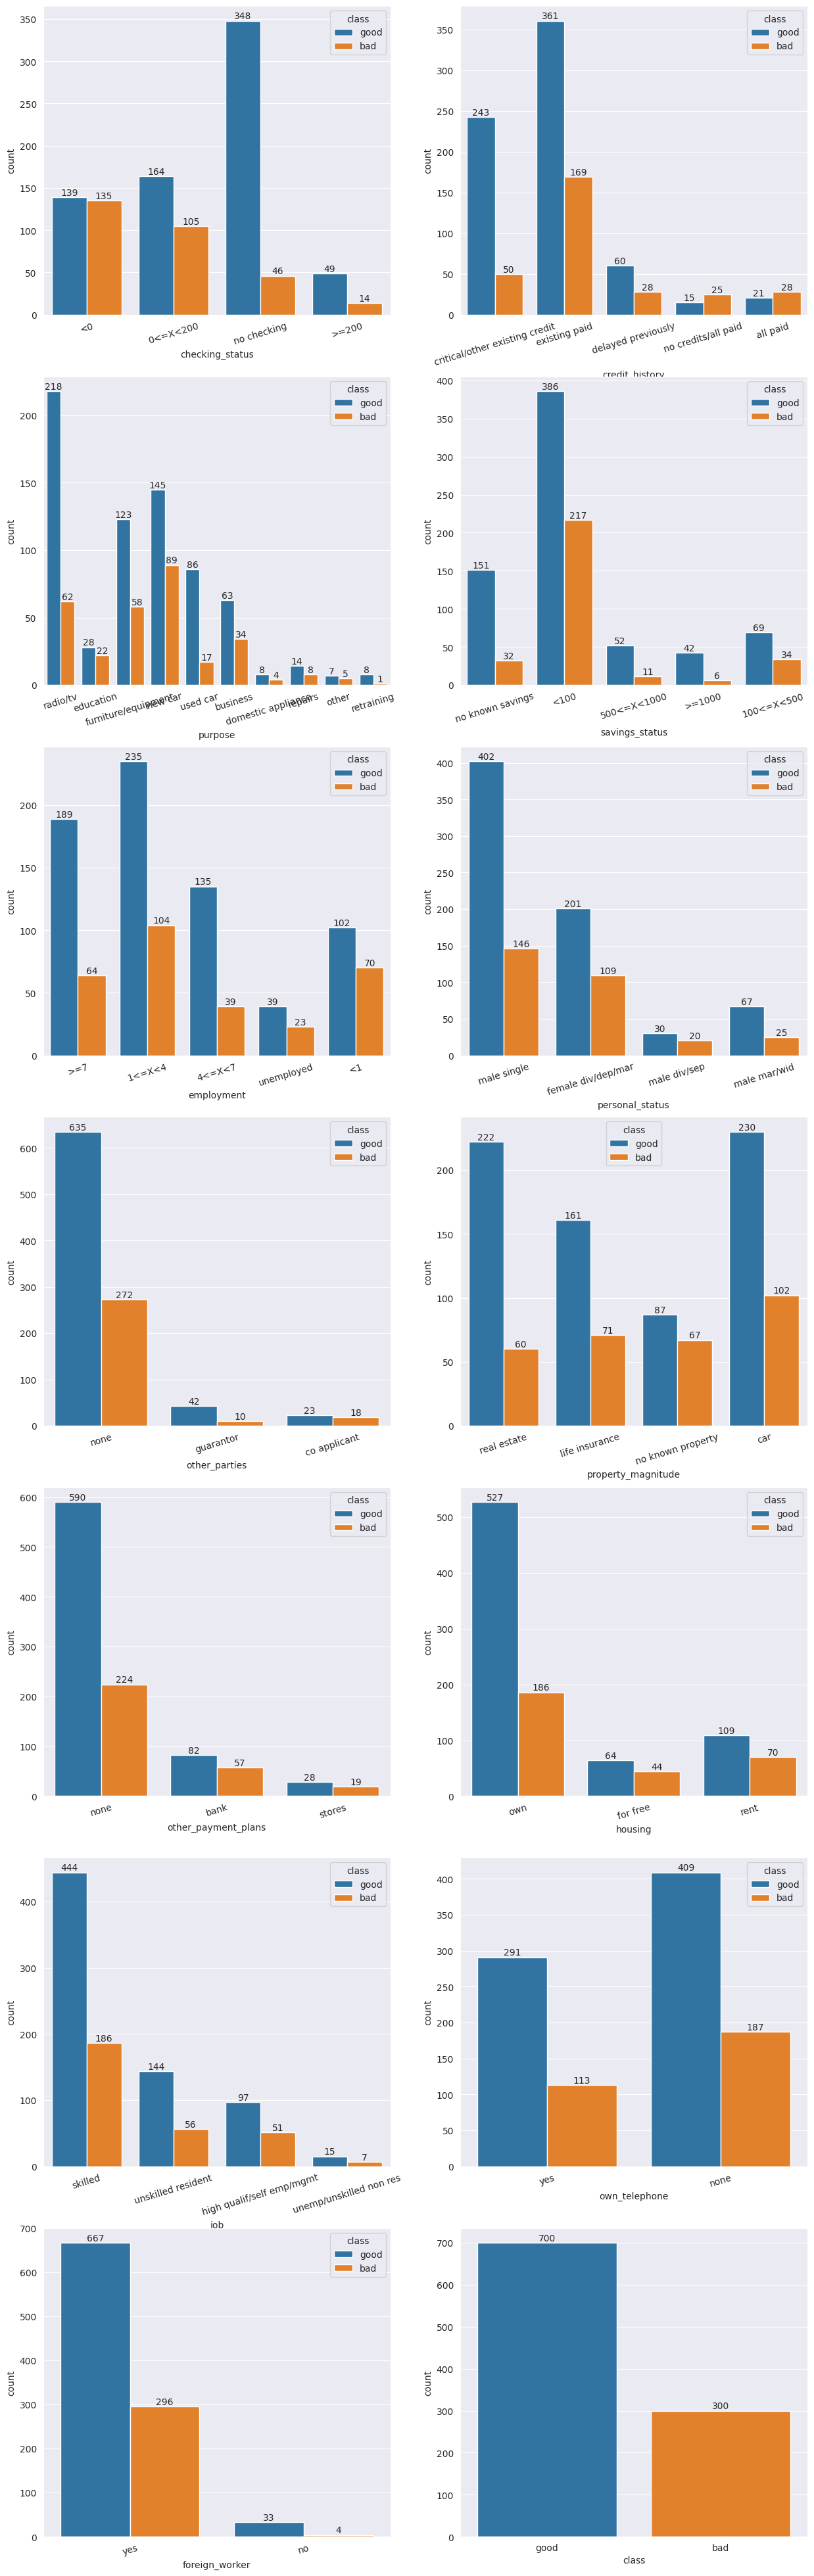

In [15]:
plt.figure(figsize=(15,50))
for i,c in enumerate(df.select_dtypes(include=["object"]).columns.tolist()):
    ax = plt.subplot(7,2,i+1)
    if c == "class":
        sns.countplot(df, x=c, ax=ax)
        for container in ax.containers:
            ax.bar_label(container)
    else:
        sns.countplot(df, x=c, hue="class", ax=ax)
        for container in ax.containers:
            ax.bar_label(container)
        plt.xticks(rotation=17)

<Axes: xlabel='existing_credits', ylabel='count'>

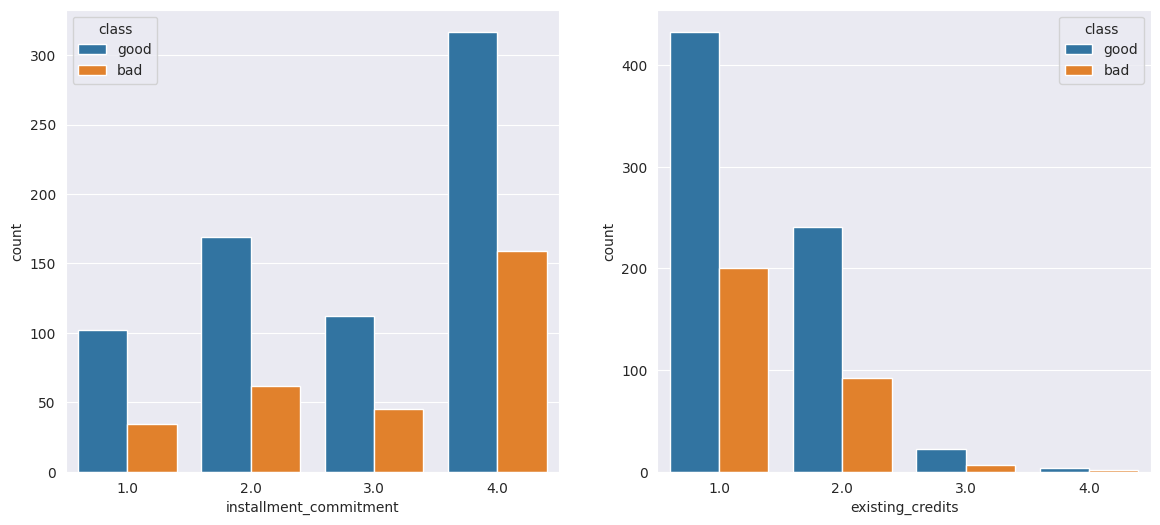

In [16]:
plt.figure(figsize=(14,6))
ax1 = plt.subplot(1,2,1)
sns.countplot(df, x="installment_commitment" , hue="class", ax=ax1)
ax2 = plt.subplot(1,2,2)
sns.countplot(df, x="existing_credits", hue="class", ax=ax2)

<Axes: xlabel='class', ylabel='duration'>

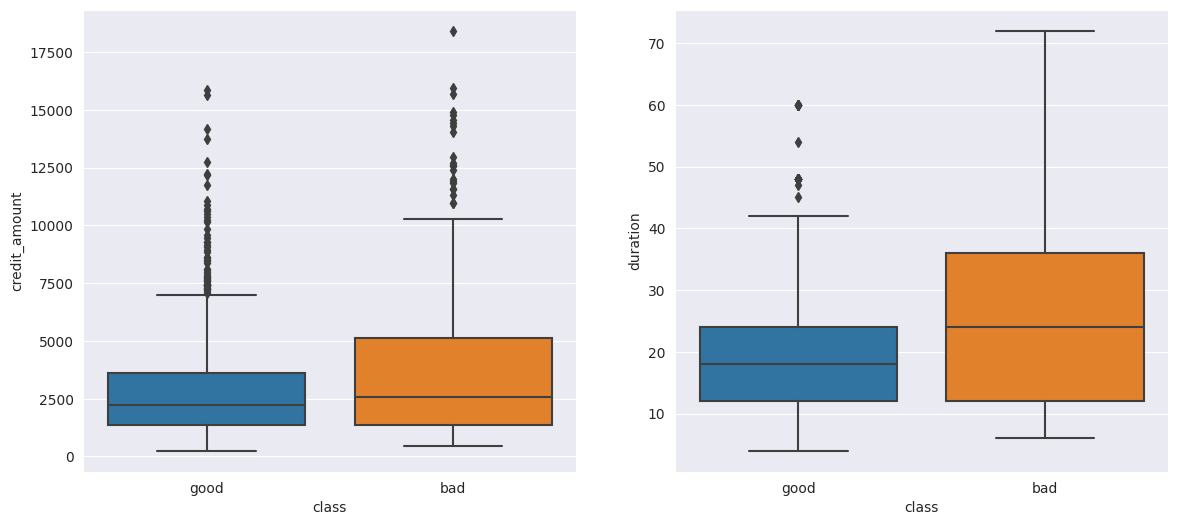

In [17]:
plt.figure(figsize=(14,6))
ax1 = plt.subplot(1,2,1)
sns.boxplot(df, y="credit_amount" , x="class", ax=ax1)
ax2 = plt.subplot(1,2,2)
sns.boxplot(df, y="duration", x="class", ax=ax2)

<Axes: xlabel='num_dependents', ylabel='count'>

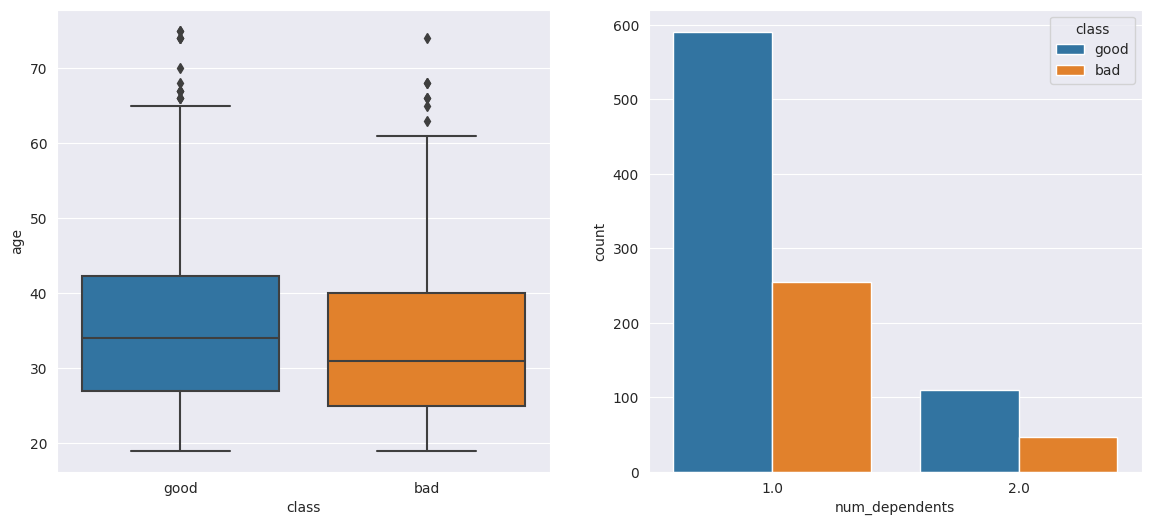

In [18]:
plt.figure(figsize=(14,6))
ax1 = plt.subplot(1,2,1)
sns.boxplot(df, y="age" , x="class", ax=ax1)
ax2 = plt.subplot(1,2,2)
sns.countplot(df, x="num_dependents", hue="class", ax=ax2)

<Axes: xlabel='credit_amount', ylabel='Count'>

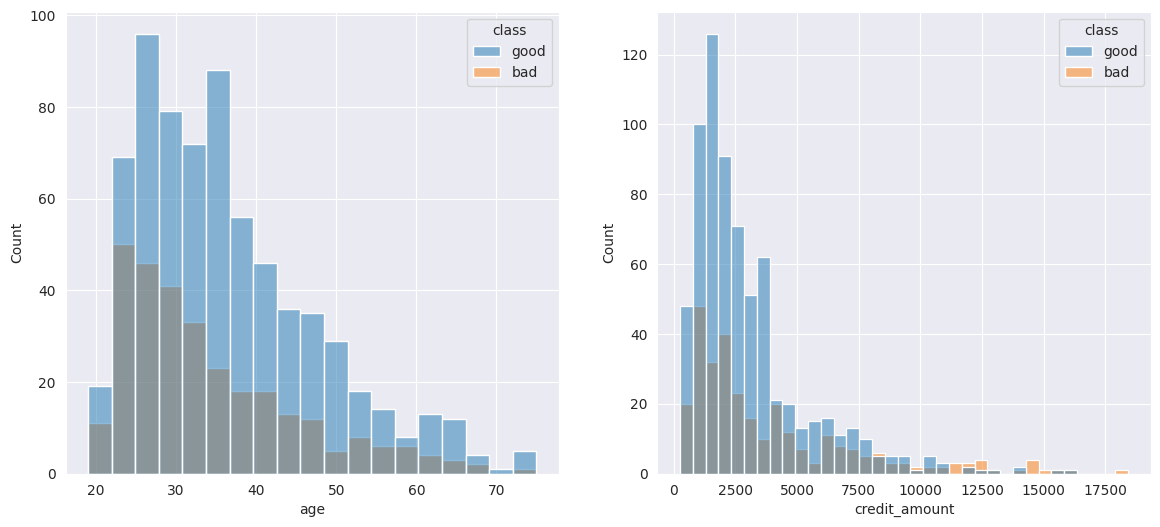

In [19]:
plt.figure(figsize=(14,6))
ax1 = plt.subplot(1,2,1)
sns.histplot(df, x="age", hue="class", ax=ax1)
ax2 = plt.subplot(1,2,2)
sns.histplot(df, x="credit_amount", hue="class", ax=ax2)

In [20]:
# ANOVA for age
age_good = df[df["class"] == "good"]["age"]
age_bad = df[df["class"] == "bad"]["age"]
f, p = stats.f_oneway(age_good, age_bad)
print(f"age\nf score: {round(f,4)}\tp-value: {round(p,4)}\n")
# ANOVA for duration
duration_good = df[df["class"] == "good"]["duration"]
duration_bad = df[df["class"] == "bad"]["duration"]
f, p = stats.f_oneway(duration_good, duration_bad)
print(f"duration\nf score: {round(f,4)}\tp-value: {round(p,4)}\n")
# ANOVA for credit_amount
credit_amount_good = df[df["class"] == "good"]["credit_amount"]
credit_amount_bad = df[df["class"] == "bad"]["credit_amount"]
f, p = stats.f_oneway(credit_amount_good, credit_amount_bad)
print(f"credit_amount\nf score: {round(f,4)}\tp-value: {round(p,4)}")

age
f score: 8.357	p-value: 0.0039

duration
f score: 48.3338	p-value: 0.0

credit_amount
f score: 24.4824	p-value: 0.0


<b>Observations:</b>
<ul>
    <li>A surprising observation is that customers with no credits or paid credits have higher chance to be bad for credit.</li>
    <li>Customers with no checking have higher chance to be bad for credit.</li>
    <li>Customers with higher duration are more likely to be bad for credit.</li>
    <li>Even though it is not very obvious there is an indication that people with higher amounts of credit are more likely to be bad for credit.</li>
    <li>Also customers of higher age tend to be better to be given credits.</li>
    <li>ANOVA showed that <span style="color:#26a06c">credit_amount</span>, <span style="color:#26a06c">duration</span> and <span style="color:#26a06c">age</span> have statistical significant difference over the target variable, which comes in agreement with the above observations from the plots.</li>
</ul>


<span style="background-color:#76d7c4;color:black;border-radius:3px;opacity:0.8;font-size:120%">Multivariate Analysis</span>

<Axes: xlabel='age', ylabel='duration'>

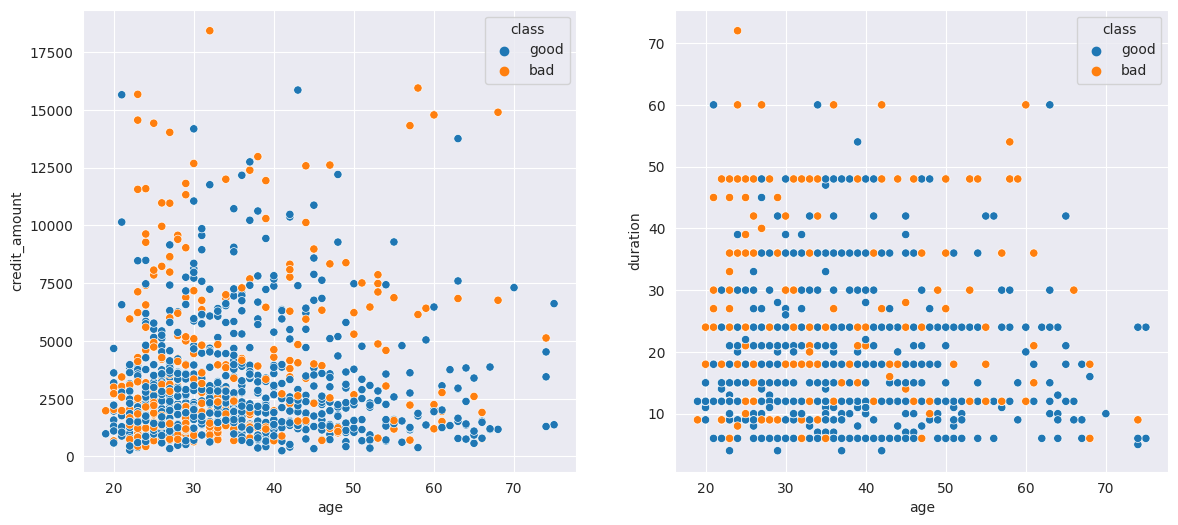

In [21]:
plt.figure(figsize=(14,6))
ax1 = plt.subplot(1,2,1)
sns.scatterplot(df, x="age", y="credit_amount", hue="class", ax=ax1)
ax2 = plt.subplot(1,2,2)
sns.scatterplot(df, x="age", y="duration", hue="class", ax=ax2)

<Axes: xlabel='housing', ylabel='age'>

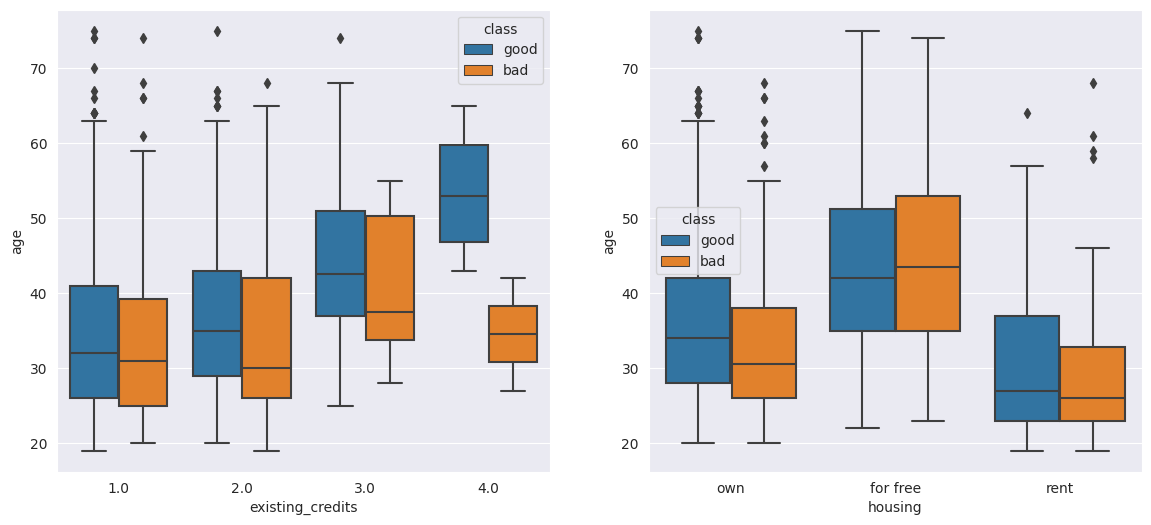

In [22]:
plt.figure(figsize=(14,6))
ax1 = plt.subplot(1,2,1)
sns.boxplot(df, y="age", x="existing_credits", hue="class", ax=ax1)
ax2 = plt.subplot(1,2,2)
sns.boxplot(df, y="age", x="housing", hue="class", ax=ax2)

<Axes: xlabel='checking_status', ylabel='credit_amount'>

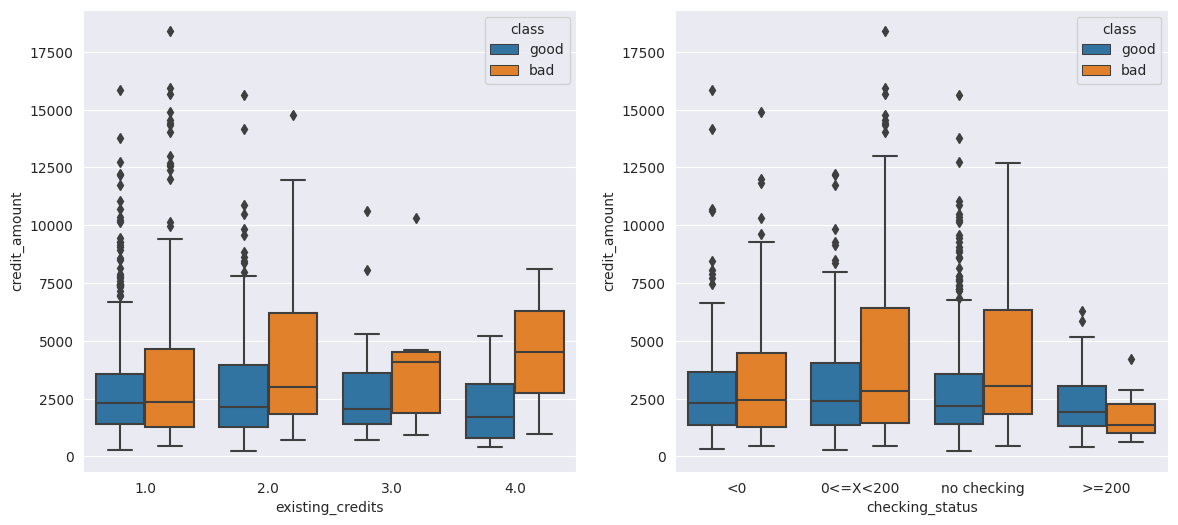

In [23]:
plt.figure(figsize=(14,6))
ax1 = plt.subplot(1,2,1)
sns.boxplot(df, y="credit_amount", x="existing_credits", hue="class", ax=ax1)
ax2 = plt.subplot(1,2,2)
sns.boxplot(df, y="credit_amount", x="checking_status", hue="class", ax=ax2)

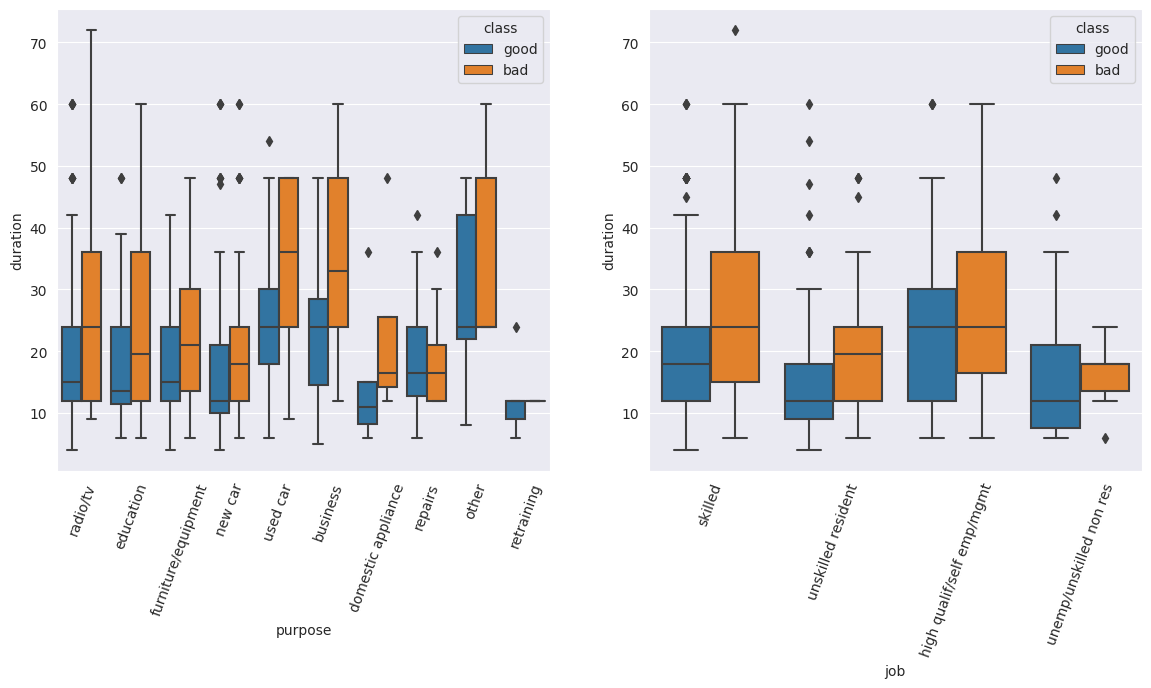

In [24]:
plt.figure(figsize=(14,6))
ax1 = plt.subplot(1,2,1)
sns.boxplot(df, y="duration", x="purpose", hue="class", ax=ax1)
plt.xticks(rotation=70)
ax2 = plt.subplot(1,2,2)
sns.boxplot(df, y="duration", x="job", hue="class", ax=ax2)
plt.xticks(rotation=70)
plt.show()

<Axes: xlabel='duration', ylabel='credit_amount'>

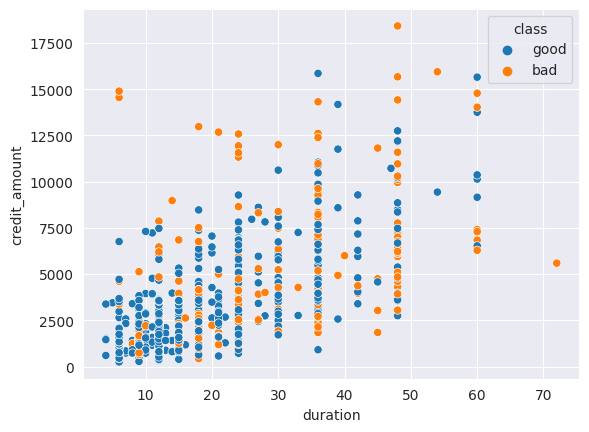

In [25]:
sns.scatterplot(df, x="duration", y="credit_amount", hue="class")

<b>Observations:</b>
<ul>
    <li>People of higher age with existing credits are better to be given credit.</li>
    <li>People of higher age that own the home their living seem also better to be given credit.</li>
    <li>The more existing credits the more credit amount makes the customer bad to be given credit.</li>
    <li>Dispite the <span style="color:#26a06c">purpose</span> biggest <span style="color:#26a06c">duration</span> have a positive impact on giving credit to the customer, except <b>repairs</b> which looks neutral.</li> 

In [26]:
# Assign numerical values to the target
df["class"] = df["class"].map({"bad": 0, "good": 1})
# Split gender and marital status
df[["gender", "marital_status"]] = df["personal_status"].str.split(" ", expand=True)

<h2>Modeling</h2>

In [27]:
# Create the train and test set
df_train, df_test = train_test_split(df, test_size=0.1, stratify=df["class"], random_state=47)
X_train, y_train = df_train.drop(columns=["class"]), df_train["class"].copy()
X_test, y_test = df_test.drop(columns=["class"]), df_test["class"].copy()

In [28]:
prepro = ColumnTransformer([
    ("cat", OneHotEncoder(), X_train.select_dtypes(include=["object"]).columns.tolist()),
    ("num", StandardScaler(), X_train.select_dtypes(exclude=["object"]).columns.tolist())
])

model = CatBoostClassifier(random_state=47, verbose=False) 

full_pipe = imbPipeline([
    ("prepro", prepro),
    ("over", RandomOverSampler(random_state=47)),
    ("model", model)
])

f1 score: 0.8374306106264869
ROC AUC score: 0.7283068783068783
              precision    recall  f1-score   support

           0       0.62      0.62      0.62       270
           1       0.84      0.84      0.84       630

    accuracy                           0.77       900
   macro avg       0.73      0.73      0.73       900
weighted avg       0.77      0.77      0.77       900



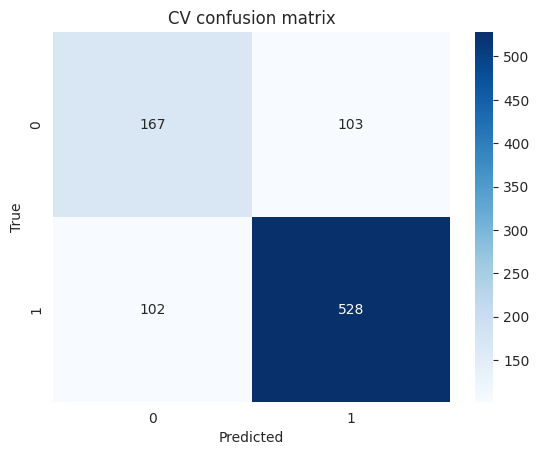

In [38]:
preds = cross_val_predict(full_pipe, X_train, y_train, cv=StratifiedKFold(n_splits=5), n_jobs=-1)
print("f1 score:", f1_score(y_train, preds))
print("ROC AUC score:", roc_auc_score(y_train, preds))
print(classification_report(y_train, preds))
cm = pd.DataFrame(confusion_matrix(y_train, preds), columns=["0", "1"], index=["0", "1"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("CV confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

<b>Results:</b>
<ul>
    <li>CatBoostClassifier was the best performing model. It achieved <span style="color:#d2b4de">f1 score</span>: <b>0.8374</b> and <span style="color:#d2b4de">ROC AUC score</span>: <b>0.7283</b> which is a good indicator that the model is severely underperforming.</li>
    <li>The model performed really poor on the minority class achieving <span style="color:#d2b4de">precision</span>: <b>0.62</b> and <span style="color:#d2b4de">recall</span>: <b>0.62</b>. Which means that the model has 62% to be correct when it predicted that a customer is bad for credit and that it find only the 62% of all customers that are bad for credit.</li>
    <li>The performance on the majority class was a lot better but still not satisfactory. The model achieved <span style="color:#d2b4de">precision</span>: <b>0.84</b> and <span style="color:#d2b4de">recall</span>: <b>0.84</b>. Which again meant that the model had 84% to be correct when predicted a customer was good for credit and it could detect 84% of all customers being good for credit.</li>
    <li>Based on the difference in performance between the manority and the majority class it's apparent that the low sample size of the manority class really hurts performance.</li>
    <li>Different over sampling techniques were tested (SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN) but <b>RandomOverSampler</b> was the best performer.</li>

<span style="background-color:#76d7c4;color:black;border-radius:3px;opacity:0.8;font-size:120%;">Model Explainability - Test set evaluation</span>

In [30]:
full_pipe.fit(X_train, y_train)

Pipeline(steps=[('prepro',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['checking_status',
                                                   'credit_history', 'purpose',
                                                   'savings_status',
                                                   'employment',
                                                   'personal_status',
                                                   'other_parties',
                                                   'property_magnitude',
                                                   'other_payment_plans',
                                                   'housing', 'job',
                                                   'own_telephone',
                                                   'foreign_worker', 'gender',
                                                   'marital_status']),
                                                 ('num', StandardScaler(),
                                                  ['duration', 'credit_amount',
                                                   'installment_commitment',
                                                   'residence_since', 'age',
                                                   'existing_credits',
                                                   'num_dependents'])])),
                ('over', RandomOverSampler(random_state=47)),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x7f37dbedeaa0>)])

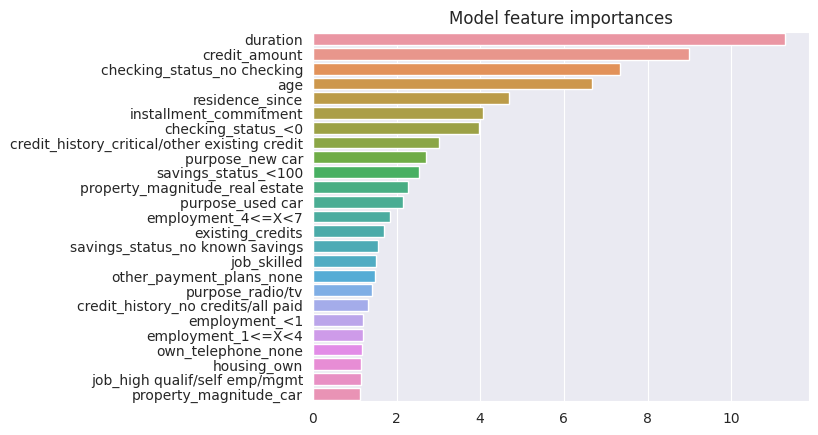

In [31]:
cat_list = prepro.transformers_[0][1].get_feature_names_out().tolist()
num_list = X_train.select_dtypes(exclude=["object"]).columns.tolist()
feature_list = cat_list + num_list
feat_imp = pd.Series(dict(zip(feature_list, full_pipe.named_steps["model"].feature_importances_))).sort_values(ascending=False).head(25)
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Model feature importances")
plt.show()

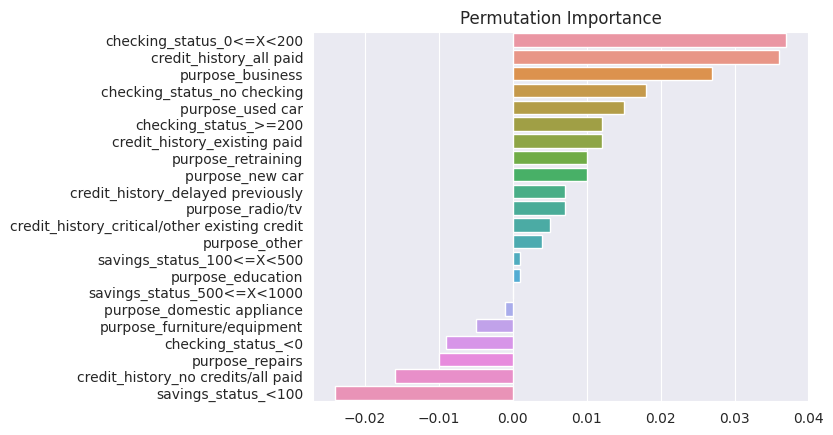

In [32]:
result = permutation_importance(full_pipe, X_test, y_test, n_repeats=10, random_state=47)
perm_imp = pd.Series(dict(zip(feature_list, result.importances_mean))).sort_values(ascending=False)
sns.barplot(x=perm_imp.values, y=perm_imp.index)
plt.title("Permutation Importance")
plt.show()

Shapley Values

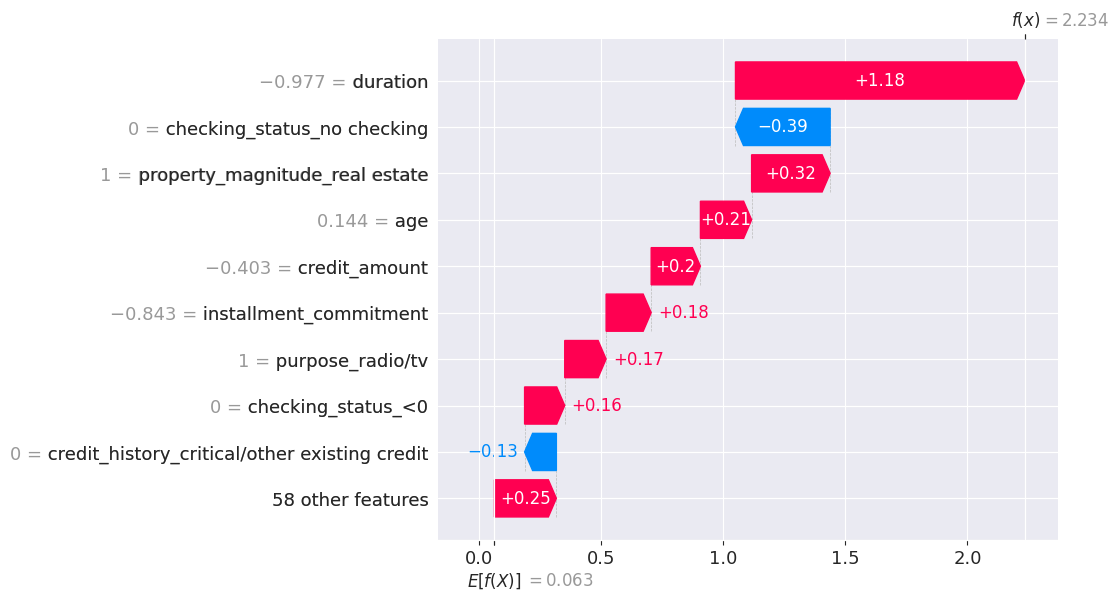

In [33]:
for c in X_train.select_dtypes("bool"):
    X_train[c] = X_train[c].astype("int64")

shap.initjs()

explainer = shap.Explainer(full_pipe[-1])
X_train_array = full_pipe[0].transform(X_train)
X_train_piped = pd.DataFrame(X_train_array, columns=feature_list)
shap_values = explainer(X_train_piped)
shap.plots.waterfall(shap_values[1])

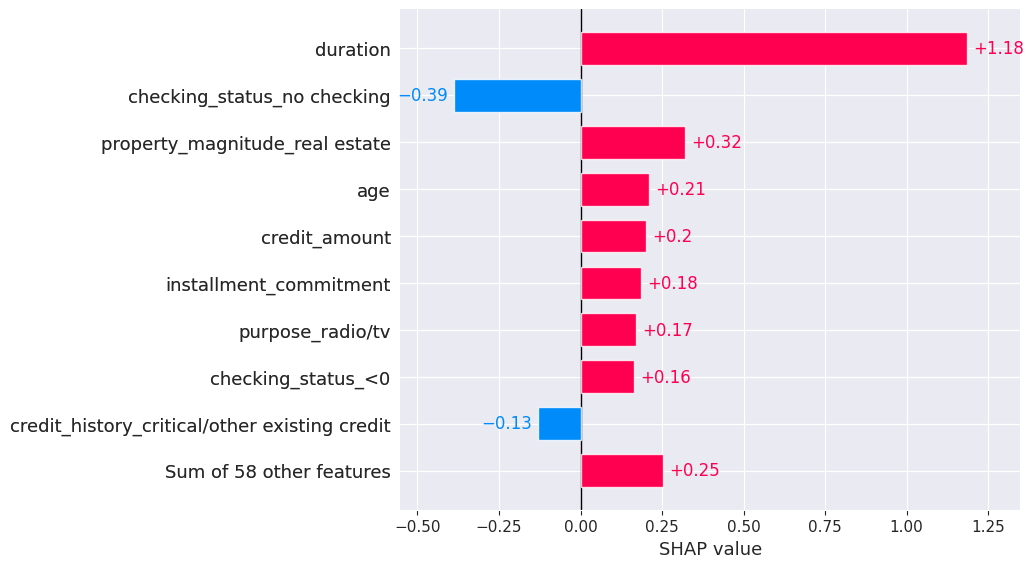

In [34]:
shap.plots.bar(shap_values[1])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


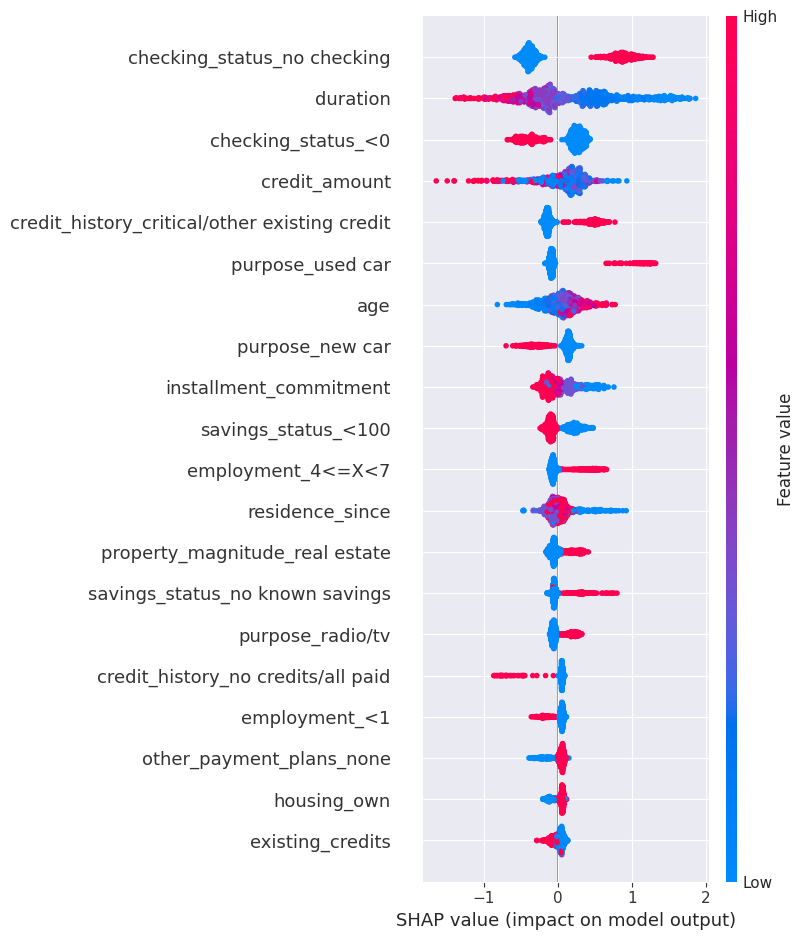

In [35]:
shap.summary_plot(shap_values)

Partial dependency plots

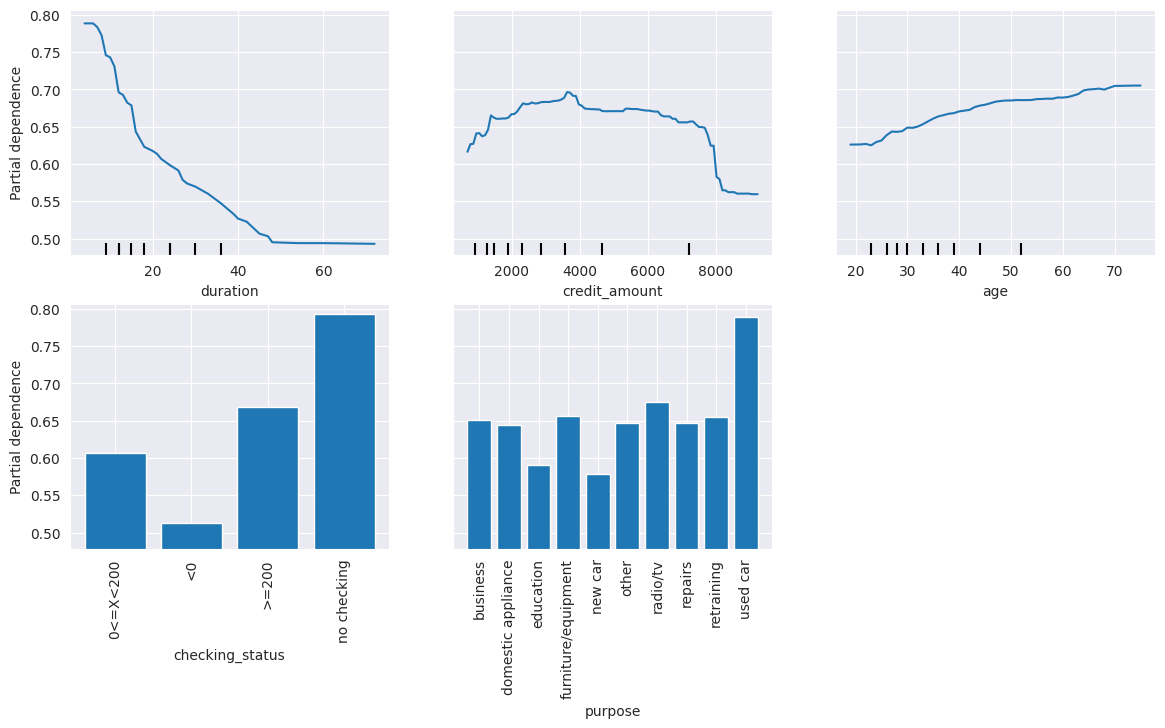

In [36]:
# Imports
fig, ax = plt.subplots(figsize=(14, 7))
disp2 = PartialDependenceDisplay.from_estimator(full_pipe, X_train, features=["duration", "credit_amount", "age", "checking_status", "purpose"], categorical_features=["checking_status", "purpose"], ax=ax)

plt.show()

<b>Results:</b>